In [3]:
import os
os.chdir("..")

In [4]:
from utils import data as data_utils
import torch_geometric as pyg
from utils import ZincWithRDKit
from datasets import DatasetDict, load_from_disk, IterableDataset
from os.path import join
import subprocess
from utils import graphormer_data_collator_improved as graphormer_collator_utils
from tqdm import tqdm
import numpy as np
import time
import yaml

from utils.modeling_graphormer_improved import (
    BetterGraphormerConfig,
    GraphormerForPretraining,
    GraphormerForGraphClassification,
)

import torch
import matplotlib.pyplot as plt

/home/alexander/miniconda3/envs/pgt_hug/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
config_file_path = "configs/pcqm4mv2_pretraining_run.yml"
pretrained_model_checkpoint = "important_checkpoints/pcqm4mv2_checkpoint_408000steps"

In [6]:
dataset_path =  "data/ZINC/processed/arrow"
#dataset_path =  "data/ZINC/processed/arrow_processed"
dataset = DatasetDict.load_from_disk(
    dataset_path, keep_in_memory=False
)

In [7]:
example_batch = [dataset["train"][i] for i in range(512)]


In [8]:
with open(config_file_path, "r") as file:
        config = yaml.safe_load(file)

In [9]:
model = GraphormerForPretraining.from_pretrained(pretrained_model_checkpoint).to("cuda")

collator = graphormer_collator_utils.GraphormerDataCollator(model_config = BetterGraphormerConfig(**config["model_args"]), on_the_fly_processing=True, collator_mode= "pretraining")

In [10]:
collated_batch = collator(example_batch)
collated_batch = {k: v.to("cuda") for k, v in collated_batch.items() if isinstance(v, torch.Tensor)}


In [11]:
res = model(**collated_batch)

In [12]:
atom_logits = res["decoded_masked_outputs_logits"][:,:,0]

In [13]:
mean_probs = torch.softmax(atom_logits, dim=-1).mean(dim=0)

In [14]:
np_mean_probs = mean_probs.detach().cpu().numpy()

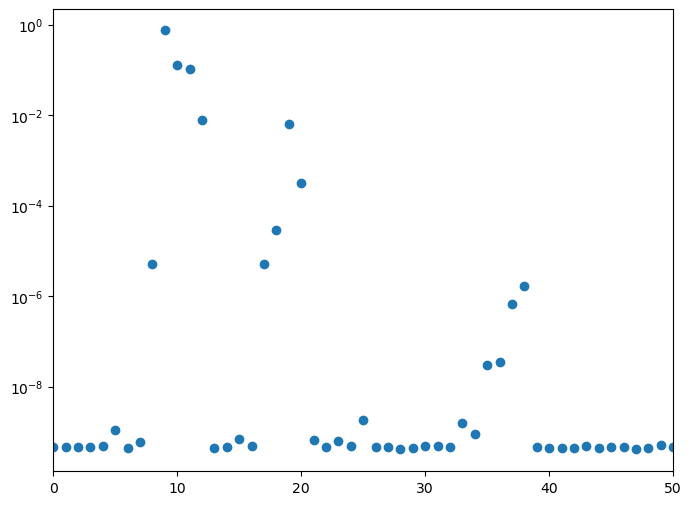

In [15]:
indices = np.arange(np_mean_probs.size)

# Create a discrete plot
plt.figure(figsize=(8, 6))
plt.scatter(indices, np_mean_probs)
plt.xlim(0, 50)
plt.yscale("log")
plt.show()

In [16]:
np.argsort(np_mean_probs)[-20:][::-1] -3 

array([ 6,  7,  8,  9, 16, 17, 15, 14,  5, 35, 34, 33, 32, 22, 30,  2, 31,
       12, 18, 20])

In [17]:
true_atoms = (collated_batch["labels"][:,0] - 3).detach().cpu().numpy()

In [18]:
unique_elements, counts = np.unique(true_atoms, return_counts=True)
probabilities = counts / true_atoms.size

# Print out probabilities
for element, prob in zip(unique_elements, probabilities):
    print(f"Element {element}: Probability {prob} - Predicted Probability {np_mean_probs[element + 3]}")

Element 6: Probability 0.7232441471571907 - Predicted Probability 0.7556486129760742
Element 7: Probability 0.12959866220735786 - Predicted Probability 0.12656907737255096
Element 8: Probability 0.1020066889632107 - Predicted Probability 0.10341334342956543
Element 9: Probability 0.014214046822742474 - Predicted Probability 0.007710593286901712
Element 16: Probability 0.023411371237458192 - Predicted Probability 0.006291940342634916
Element 17: Probability 0.007525083612040134 - Predicted Probability 0.000324172229738906




Atom Property Index: 0



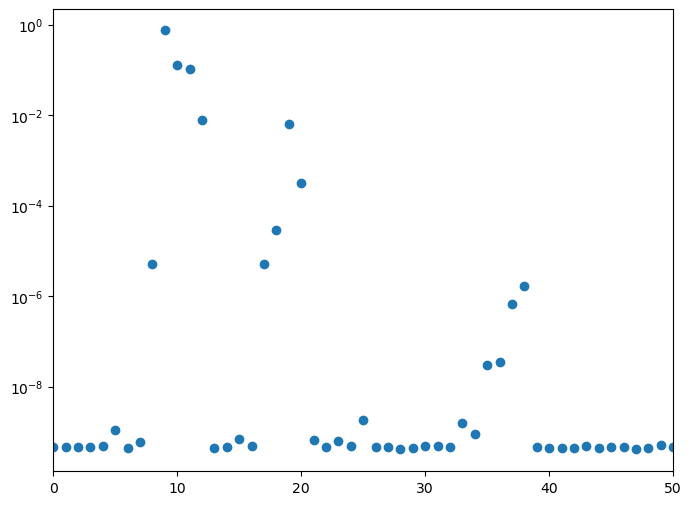

Element 6: Probability 0.7232441471571907 - Predicted Probability 0.7556486129760742
Element 7: Probability 0.12959866220735786 - Predicted Probability 0.12656907737255096
Element 8: Probability 0.1020066889632107 - Predicted Probability 0.10341334342956543
Element 16: Probability 0.023411371237458192 - Predicted Probability 0.006291940342634916
Element 9: Probability 0.014214046822742474 - Predicted Probability 0.007710593286901712
Element 17: Probability 0.007525083612040134 - Predicted Probability 0.000324172229738906
Remaining Predicted Probability: 4.226036253385246e-05


Atom Property Index: 1



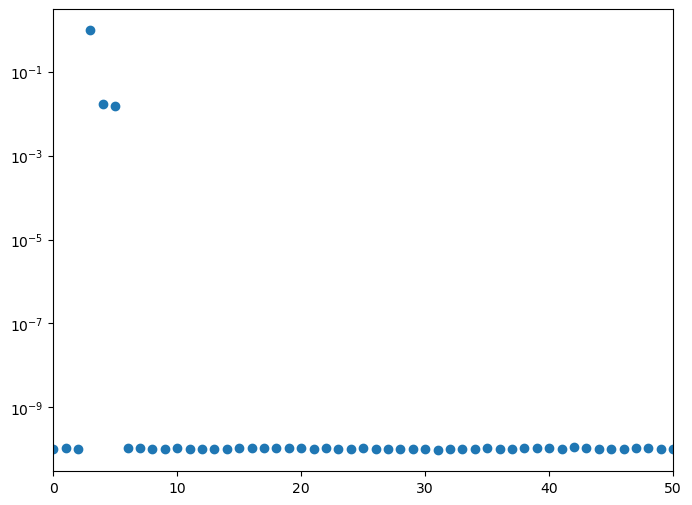

Element 0: Probability 1.0 - Predicted Probability 0.9681155681610107
Remaining Predicted Probability: 0.03188443183898926


Atom Property Index: 2



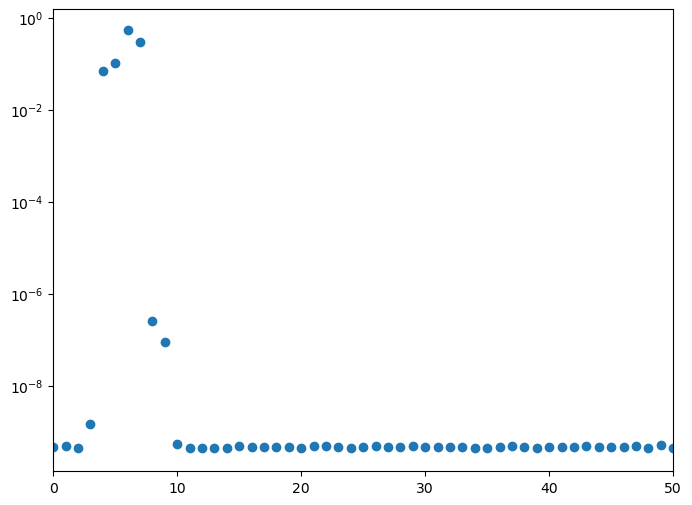

Element 3: Probability 0.5209030100334449 - Predicted Probability 0.5353487133979797
Element 4: Probability 0.28678929765886285 - Predicted Probability 0.2935025990009308
Element 1: Probability 0.09949832775919733 - Predicted Probability 0.06904838234186172
Element 2: Probability 0.09280936454849498 - Predicted Probability 0.10209973901510239
Remaining Predicted Probability: 5.662441253662109e-07


Atom Property Index: 3



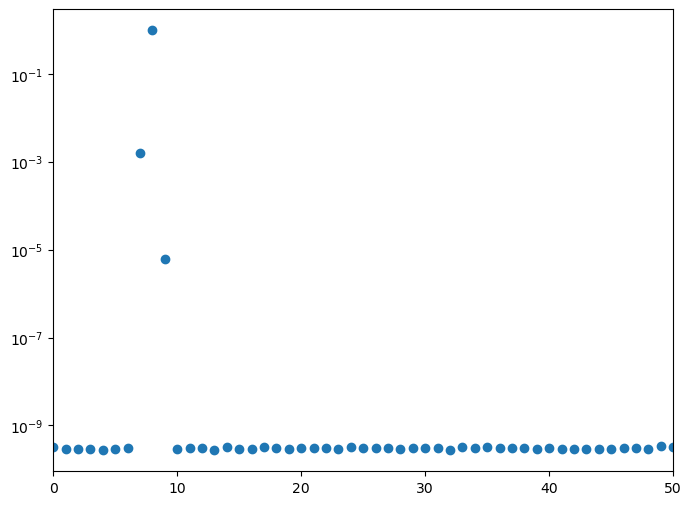

Element 5: Probability 0.9765886287625418 - Predicted Probability 0.998429000377655
Element 6: Probability 0.017558528428093644 - Predicted Probability 6.178216153784888e-06
Element 4: Probability 0.005852842809364548 - Predicted Probability 0.001564684440381825
Remaining Predicted Probability: 1.3696580936084501e-07


Atom Property Index: 4



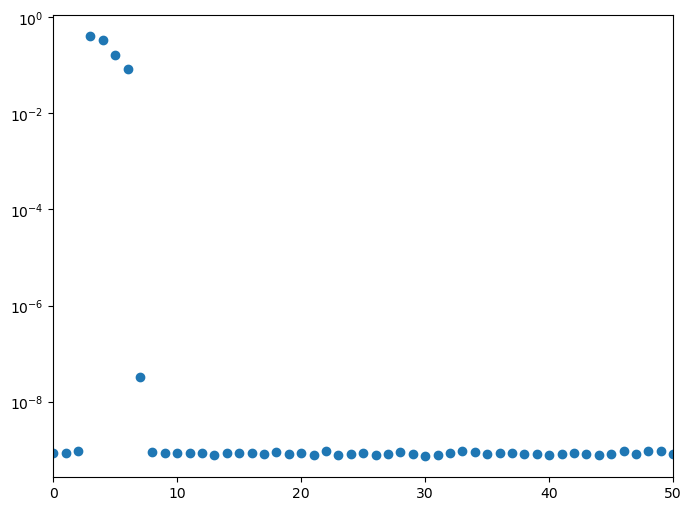

Element 0: Probability 0.431438127090301 - Predicted Probability 0.4033981263637543
Element 1: Probability 0.33612040133779264 - Predicted Probability 0.3448565900325775
Element 2: Probability 0.1596989966555184 - Predicted Probability 0.168140709400177
Element 3: Probability 0.07274247491638795 - Predicted Probability 0.0836041271686554
Remaining Predicted Probability: 4.470348358154297e-07


Atom Property Index: 5



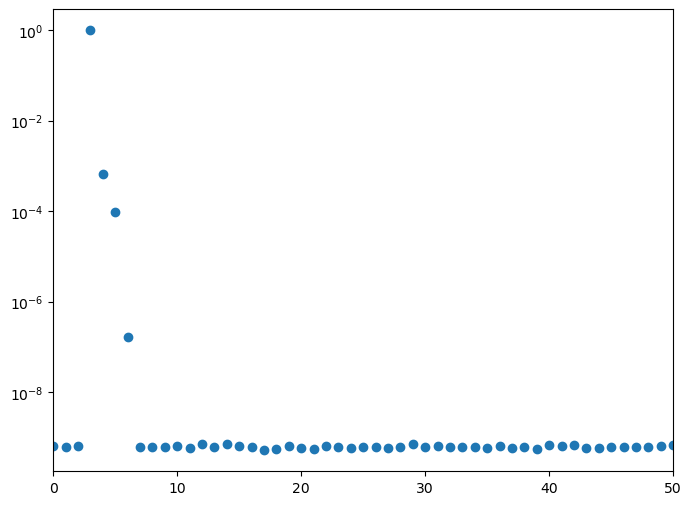

Element 0: Probability 1.0 - Predicted Probability 0.9992302060127258
Remaining Predicted Probability: 0.0007697939872741699


Atom Property Index: 6



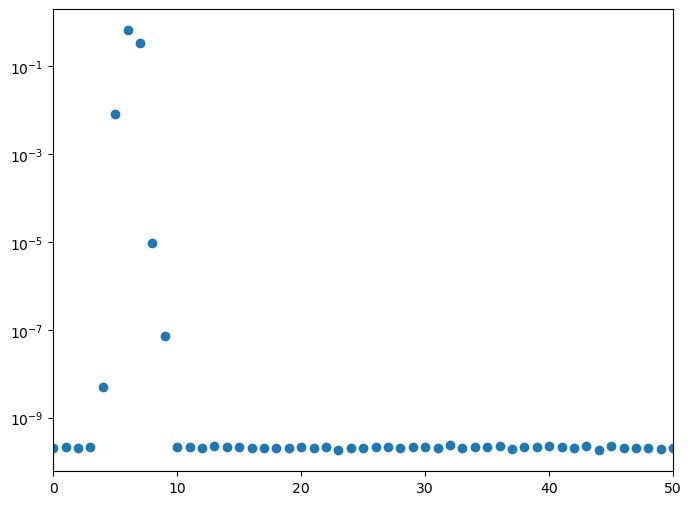

Element 3: Probability 0.6538461538461539 - Predicted Probability 0.6538741588592529
Element 4: Probability 0.3377926421404682 - Predicted Probability 0.33775439858436584
Element 2: Probability 0.008361204013377926 - Predicted Probability 0.008361879736185074
Remaining Predicted Probability: 9.562820196151733e-06


Atom Property Index: 7



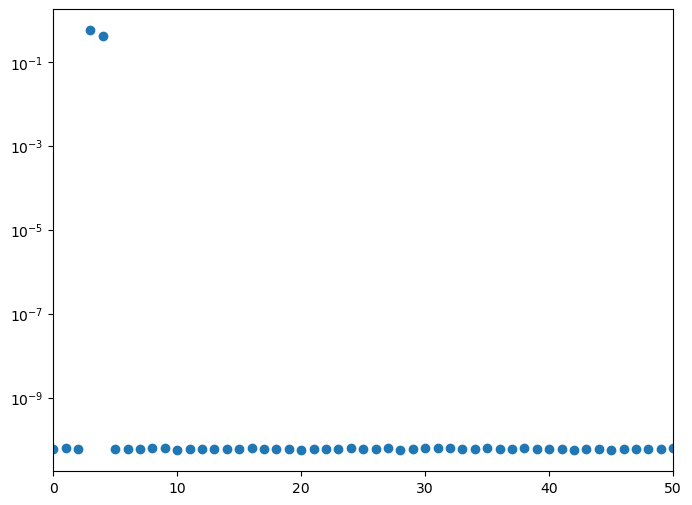

Element 0: Probability 0.5735785953177257 - Predicted Probability 0.573515772819519
Element 1: Probability 0.42642140468227424 - Predicted Probability 0.42648422718048096
Remaining Predicted Probability: 0.0


Atom Property Index: 8



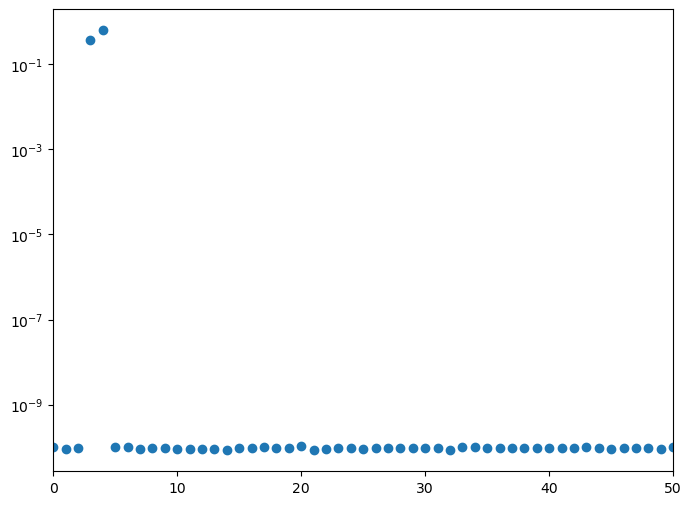

Element 1: Probability 0.6237458193979933 - Predicted Probability 0.622761607170105
Element 0: Probability 0.3762541806020067 - Predicted Probability 0.377238392829895
Remaining Predicted Probability: 0.0


In [19]:
decoded_masked_output_logits = res["decoded_masked_outputs_logits"]
for atom_property_index in range(decoded_masked_output_logits.shape[-1]):
    print(f"\n\nAtom Property Index: {atom_property_index}\n")

    atom_logits = decoded_masked_output_logits[:,:,atom_property_index]
    mean_probs = torch.softmax(atom_logits, dim=-1).mean(dim=0)
    np_mean_probs = mean_probs.detach().cpu().numpy()

    indices = np.arange(np_mean_probs.size)

    # Create a discrete plot
    plt.figure(figsize=(8, 6))
    plt.scatter(indices, np_mean_probs)
    plt.xlim(0, 50)
    plt.yscale("log")
    plt.show()

    np.argsort(np_mean_probs)[-20:][::-1] -3 
    true_atoms = (collated_batch["labels"][:,atom_property_index] - 3).detach().cpu().numpy()

    unique_elements, counts = np.unique(true_atoms, return_counts=True)
    probabilities = counts / true_atoms.size

    sorted_indices = np.argsort(probabilities)[::-1]

    unique_elements = unique_elements[sorted_indices]
    probabilities = probabilities[sorted_indices]

    # Print out probabilities
    acc_prob = 0
    for element, prob in zip(unique_elements, probabilities):
        print(f"Element {element}: Probability {prob} - Predicted Probability {np_mean_probs[element + 3]}")
        acc_prob += np_mean_probs[element + 3]

    print(f"Remaining Predicted Probability: {1 - acc_prob}")

# ZINC pretrained vs from Scratch

In [8]:
import wandb

api = wandb.Api()
runs = api.runs("alexanderkrauck/pretrained_graph_transformer")

In [29]:
runs_from_scratch = [run for run in runs if "zinc_no_pretrain" in run.name]
runs_pretrained = [run for run in runs if "zinc_on_pretrained" in run.name]

eval_loss_scratch = [run.history(keys=["eval/loss", "train/global_step"]) for run in runs_from_scratch]
eval_loss_pretrained = [run.history(keys=["eval/loss", "train/global_step"]) for run in runs_pretrained]


In [15]:
print(len(runs_from_scratch), len(runs_pretrained))
print(len(eval_loss_scratch), len(eval_loss_pretrained))

10 10
10 10


In [28]:
eval_loss_scratch[0].keys()

Index(['_step', 'eval/loss', 'train/global_step'], dtype='object')

In [60]:
import matplotlib.pyplot as plt
import numpy as np

def interpolate_runs_and_get_mean(histories):
    interpolated_losses = []
    max_global_step = max(list(history["train/global_step"])[-1] for history in histories)
    steps = np.arange(0, max_global_step, step=100)  # adjust step size as needed

    for history in histories:
        interpolated_loss = np.interp(steps, history["train/global_step"], history["eval/loss"], left=np.nan, right=np.nan)
        interpolated_losses.append(interpolated_loss)

    interpolated_mean = np.nanmean(interpolated_losses, axis=0)
    print(interpolated_mean[-20:])
    return interpolated_mean, steps

# Function to plot a set of runs
def plot_runs(histories, label, color):


    interplated_mean, interpolated_steps = interpolate_runs_and_get_mean(histories)

    max_length = max(len(history) for history in histories)
    min_length = min(len(history) for history in histories)

    # Plot individual runs
    for history in histories:
        plt.plot(history["train/global_step"], history["eval/loss"], color=color, alpha=0.1)

    # Compute and plot the mean over runs

    plt.plot(interpolated_steps, interplated_mean, label=label, color=color)



In [42]:
list(eval_loss_scratch[0]["train/global_step"])[-1]

139000

In [46]:


interplated_mean_scratch, interpolated_steps_scratch = interpolate_runs_and_get_mean(eval_loss_scratch)
interplated_mean_pretrained, interpolated_steps_pretrained = interpolate_runs_and_get_mean(eval_loss_pretrained)


[0.52643664 0.52646853 0.52650041 0.5265323  0.52654847 0.52650178
 0.52644623 0.52635524 0.52626425 0.52620263 0.5261304  0.52605818
 0.52597788 0.49869587 0.49866282 0.49862978 0.49859674 0.49856369
 0.49861058 0.49871075]
[0.16429655 0.16398992 0.16469197 0.16520841 0.16530402 0.16542006
 0.16504601 0.16474565 0.1645255  0.15640116 0.1558006  0.15528625
 0.15532216 0.11681253 0.12433729 0.12439737 0.12449821 0.09520558
 0.09709594 0.10299871]


/tmp/ipykernel_42846/1355454591.py:13: RuntimeWarning: Mean of empty slice
  interpolated_mean = np.nanmean(interpolated_losses, axis=0)
/tmp/ipykernel_42846/1355454591.py:13: RuntimeWarning: Mean of empty slice
  interpolated_mean = np.nanmean(interpolated_losses, axis=0)


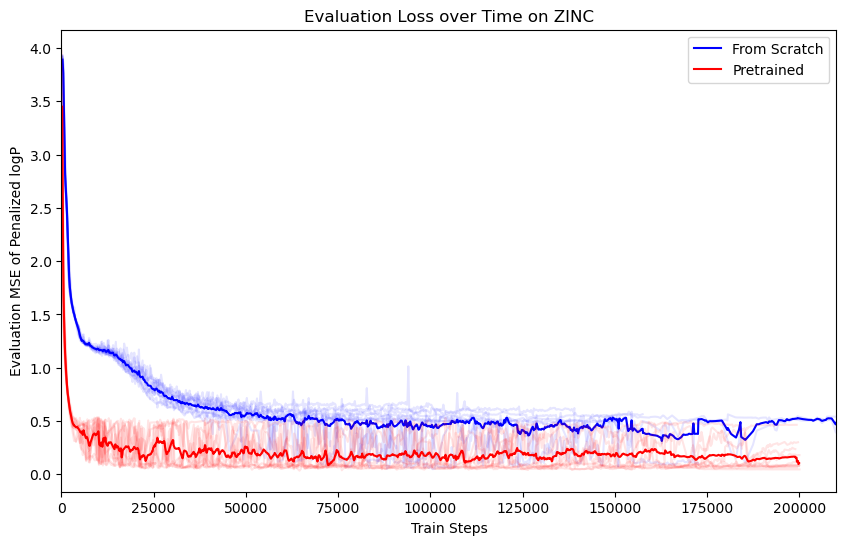

In [69]:
plt.figure(figsize=(10, 6))
plot_runs(eval_loss_scratch, 'From Scratch', 'blue')
plot_runs(eval_loss_pretrained, 'Pretrained', 'red')
plt.title('Evaluation Loss over Time on ZINC')
plt.xlabel('Train Steps')
plt.ylabel('Evaluation MSE of Penalized logP')
plt.legend()
plt.xlim(0, 210000)
plt.show()

# Dataset num nodes comparison

In [9]:
from datasets import DatasetDict, load_from_disk
import numpy as np
import matplotlib.pyplot as plt

In [4]:


data_dir = "data/"
dir_suffix = "/processed/arrow/"

datasets = {
    "ZINC": DatasetDict.load_from_disk(data_dir + "ZINC" +dir_suffix, keep_in_memory=False)["train"],
    "PCQM4Mv2": load_from_disk(data_dir + "pcqm4mv2"+ dir_suffix, keep_in_memory=False),
    "Tox21": load_from_disk(data_dir + "tox21"+ dir_suffix, keep_in_memory=False),
    "Tox21_Original": DatasetDict.load_from_disk(data_dir + "tox21_original"+ dir_suffix, keep_in_memory=False)["train"],
    "QM9": load_from_disk(data_dir + "qm9"+ dir_suffix, keep_in_memory=False),
    "PCBA": load_from_disk(data_dir + "pcba"+ dir_suffix, keep_in_memory=False)
}

In [7]:
num_nodes_dict = {}
for dataset_name in datasets:
    dataset = datasets[dataset_name]
    num_nodes_list = []
    for molecule in dataset:
        num_nodes_list.append(molecule["num_nodes"])
    num_nodes_dict[dataset_name] = num_nodes_list

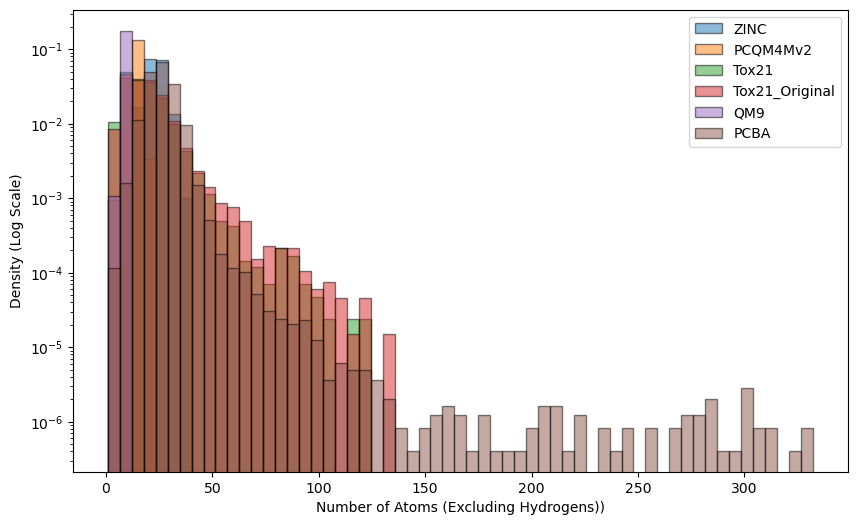

In [29]:
# Get the minimum and maximum values among all datasets
min_value = min([min(v) for v in num_nodes_dict.values()])
max_value = max([max(v) for v in num_nodes_dict.values()])

# Define bins for your histogram
bins = np.linspace(min_value, max_value, 60)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern Roman'
plt.rcParams['text.usetex'] = False


plt.figure(figsize=(10, 6))
# Plot a histogram for each list in the dictionary
for dataset, values in num_nodes_dict.items():
    plt.hist(values, bins, alpha=0.5, label=dataset, density=True, edgecolor='black')

# Set labels and title
plt.xlabel('Number of Atoms (Excluding Hydrogens))')
plt.ylabel('Density (Log Scale)')
plt.yscale('log')

#plt.title('Density of Number of Atoms in Molecules across Datasets')

# Show a legend
plt.legend(loc='upper right')

# Show the plot
plt.show()

In [26]:
for dataset_name in num_nodes_dict:
    num_nodes = num_nodes_dict[dataset_name]
    print(dataset_name, np.quantile(num_nodes, 0.9999))

ZINC 37.0
PCQM4Mv2 20.0
Tox21 116.44599999999991
Tox21_Original 123.64860000000044
QM9 9.0
PCBA 208.41440000000875


In [27]:
np.sum(np.array(num_nodes_dict["PCBA"]) > 150)

69

In [28]:
max(num_nodes_dict["PCBA"])

332